# Clasificador Olivo/gramíneas a partir de una red pre-entrenada:

### GPU disponible:

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Modelo InceptionResNetV2:

In [2]:
import sys
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import  Convolution2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras import applications
K.clear_session()

Using TensorFlow backend.


Se carga el modelo InceptionResNetV2: 

keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Este modelo contiene los pesos obtenidos con el pre-entrenamiento en ImageNet. Por defecto, establece una imagen de entrada de 299x299.

In [3]:
InceptionResNetV2 = applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(480, 640, 3), classes=2)#Cargamos la red
InceptionResNetV2.summary()#Muestra el contenido de la red.

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 239, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 239, 319, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 239, 319, 32) 0           batch_normalization_1[0][0]      
_____________________________________

activation_141 (Activation)     (None, 28, 38, 192)  0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 28, 38, 192)  0           batch_normalization_144[0][0]    
__________________________________________________________________________________________________
block17_17_mixed (Concatenate)  (None, 28, 38, 384)  0           activation_141[0][0]             
                                                                 activation_144[0][0]             
__________________________________________________________________________________________________
block17_17_conv (Conv2D)        (None, 28, 38, 1088) 418880      block17_17_mixed[0][0]           
__________________________________________________________________________________________________
block17_17 (Lambda)             (None, 28, 38, 1088) 0           block17_16_ac[0][0]              
          

Se ha pasado como argumento include_top=False. La red InceptionResNetV2 que aporta keras contiene por defecto una última capa de predicción de mil neuronas (para clasificar mil clases diferentes). La red que se busca solo clasificará dos clases diferentes. Con include_top=False se elimina esta última capa. En la siguiente línea de código se carga la red al completo:

### Modificación de la última capa:

Se diseña la capa de salida para realizar la clasificación. Constará de:

Capa GlobalAveragePooling2D.

Capa tipo Dense de 1000 neuronas y activación rectificador (relu)

In [4]:
# add a global spatial average pooling layer
x = InceptionResNetV2.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(800, activation='relu')(x)
#To reduce overfitting...
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=InceptionResNetV2.input, outputs=predictions)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 239, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 239, 319, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 239, 319, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
activation_162 (Activation)     (None, 28, 38, 288)  0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 13, 18, 384)  884736      activation_157[0][0]             
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 13, 18, 288)  663552      activation_159[0][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 13, 18, 320)  829440      activation_162[0][0]             
__________________________________________________________________________________________________
batch_normalization_158 (BatchN (None, 13, 18, 384)  1152        conv2d_158[0][0]                 
__________

In [ ]:
model.layers

### Congelación de capas:

Se ha cargado la red pre-entrenada InceptionResNetV2, con los pesos de Imagenet. De esta forma las capas convolucionales y pooling que la forman actuarán como diferenciadoras de características, que serán usadas por la capa final que se ha incluido para realizar la clasificación.

Por tanto, se va a usar una red que ya ha 'aprendido' a clasificar en otros problemas, y se va a adaptar para el problema que aquí se trata (TRANSFER LEARNING).

Es por esto que no es necesario entrenar todas las capas de la red, y solo se entrenarán las 3 capas que se han añadido, congelando las demás.

In [6]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

In [7]:
for layer in model.layers[:780]:
   layer.trainable = False
for layer in model.layers[780:]:
   layer.trainable = True

In [ ]:
model.summary()

### Tratamiento de las imágenes:

Se necesita adaptar el conjunto de imágenes para poder ser tratado por el modelo. Para ello se van a usar las funciones flow_from_directory() y ImageDataGenerator().

In [13]:
#Se almacenan en variables los directorios en los que se encuentran las imágenes
data_entrenamiento = './data_polen/entrenamiento'
data_validacion = './data_polen/validacion'

#Parámetros importantes:
epocas=15
longitud, altura = 640, 480
batch_size = 22 #Imágenes a procesar en cada paso
pasos = 10
validation_steps = 10 #Imágenes de validación que se pasan al final de cada época
clases = 2
lr = 0.00085 #Learning rate

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

Con la función flow_from_directory() se pre-procesan las imágenes que se encuentran en los directorios previamente declarados. Además se le puede pasar como parámetros el tamaño al que se redimensionan las imágenes, o el algoritmo de interpolación.

keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

Gracias a la función ImageDataGenerator() se aplica al set de entrenamiento mecanismos de DATA ARGUMENTATION como inclinar, hacer zoom o invertir las imágenes.

In [14]:
###Procesamiento del conjunto de entrenamieto:
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    shear_range=0.2, #Inclina las imágenes
    zoom_range=0.2, #Zoom a algunas imágenes
    horizontal_flip=True) #Invierte imágenes para distinguir direcionalidad

###Procesamiento del conjunto de validación:
#No es necesario inclinar, hacer zoom ni invertir las imágenes.
test_datagen = ImageDataGenerator(rescale=1. / 255)

###Generación del conjunto de entrenamieto:
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical') #Se busca una clasificación categórica

###Generación del conjunto de validación:
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')

print(entrenamiento_generador.class_indices)

Found 54 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
{'gramineas': 0, 'olivo': 1}


### Definición del modelo CNN: función pérdida y optimizador:

In [15]:
model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=lr),
            metrics=['accuracy'])

### GPU

In [11]:
## COMPROBAR DISPOSITIVO GPU ##

# Importa las librerías necesarias
import tensorflow as tf

# Comprueba la existencia de un GPU para utilizar tensorflow
device_name = tf.test.gpu_device_name()
print('device_name', type(device_name))
if device_name != '/device:GPU:0':
  print('Dispositivo GPU no encontrado!!!')
else:
  print('Dispositivo GPU en posicion: {}'.format(device_name))

# Habilita el crecimiento de la memoria en el GPU 
# Si existen otros proyectos con sesion abierta consumiran memoria
# y no se podra ejecutar la prediccion 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

device_name <class 'str'>
Dispositivo GPU en posicion: /device:GPU:0


### Entrenamiento del modelo:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

In [16]:
H = model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=len(entrenamiento_generador),
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=validation_steps)

Epoch 1/15
3/3 [==============================] - 107s 36s/step - loss: 0.7632 - acc: 0.5640 - val_loss: 0.4716 - val_acc: 0.9000
Epoch 2/15
3/3 [==============================] - 70s 23s/step - loss: 0.3203 - acc: 0.8880 - val_loss: 0.3511 - val_acc: 0.9500
Epoch 3/15
3/3 [==============================] - 70s 23s/step - loss: 0.2262 - acc: 0.9407 - val_loss: 0.2425 - val_acc: 1.0000
Epoch 4/15
3/3 [==============================] - 70s 23s/step - loss: 0.2653 - acc: 0.9111 - val_loss: 0.2034 - val_acc: 0.9000
Epoch 5/15
3/3 [==============================] - 70s 23s/step - loss: 0.1214 - acc: 1.0000 - val_loss: 0.1843 - val_acc: 0.9500
Epoch 6/15
3/3 [==============================] - 70s 23s/step - loss: 0.1036 - acc: 0.9840 - val_loss: 0.1329 - val_acc: 1.0000
Epoch 7/15
3/3 [==============================] - 70s 23s/step - loss: 0.0550 - acc: 1.0000 - val_loss: 0.1162 - val_acc: 1.0000
Epoch 8/15
3/3 [==============================] - 70s 23s/step - loss: 0.0593 - acc: 1.0000 - va

### Gráficas con resultados del entrenamiento:

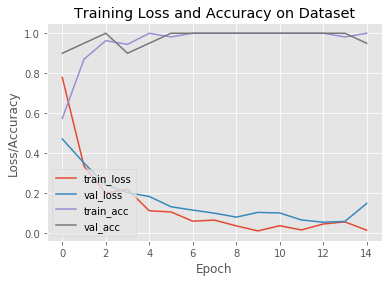

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")#Se guarda la gráfica en disco

### Cálculo de la función pérdida:

El método evaluate_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0) se encarga de calcular la función de pérdida dados unos datos de entrada y el nivel de aciertos del modelo para una muestra dada.

In [18]:
score = model.evaluate_generator(validacion_generador, steps=pasos, verbose=1)
print('Test accuracy:', score[1])
print('Loss:', score[0])

10/10 [==============================] - 59s 6s/step
Test accuracy: 0.949999988079071
Loss: 0.14935824573040007


### Guardar el modelo entrenado:

Para no tener que entrenar la red neuronal creada cada vez que se quiera usar, se crea un archivo donde se guarda el modelo creado, y otro donde se guardan los pesos obtenidos para las neuronas después del entranmiento.

In [ ]:
import os 
dir = './InceptionResNetV2_OliGram_Prueba/'
if not os.path.exists(dir):
    os.mkdir(dir)
model.save('./InceptionResNetV2_OliGram_Prueba/modelo_InceptionResNetV2.h5')#Se guarda la estructura de la cnn
model.save_weights('./InceptionResNetV2_OliGram_Prueba/pesos_InceptionResNetV2.h5')#Se guardan los pesos de la cnn

### Pruebas de clasificación:

In [19]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

La función load_image() transforma de forma interna las imágenes, tomando como argumento las dimensiones que admiten las arquitecturas implementadas y un método de interpolación. Se recomienda usar métodos de interpolación como bicubic o lanczos, frente a nearest que viene por defecto.

In [20]:
###Función predicción:
def predict(file):
  x = load_img(file, target_size=(altura, longitud))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0) #Zero mean pre-processing, normalize data.
  array = model.predict(x)
  print(array)  
  result = array[0]
  print(result)
  answer = np.argmax(result)
  print(answer)  
  if answer == 0:
    print("pred: Gramineas")
  elif answer == 1:
    print("pred: Olivo")
  return answer

In [21]:
predict('olivo1.jpg') #Imagen de olivo

[[1. 0.]]
[1. 0.]
0
pred: Gramineas


0

In [22]:
predict('graminea2.jpg') #Imagen de graminea

[[1. 0.]]
[1. 0.]
0
pred: Gramineas


0

In [18]:
predict('WIN_20190625_21_13_02_Pro.jpg') #Imagen de graminea del dataset de entrenamiento

[[8.892345e-10 1.000000e+00]]
[8.892345e-10 1.000000e+00]
1
pred: Olivo


1

In [23]:
predict('olivo4.jpg') #Imagen de olivo

[[1. 0.]]
[1. 0.]
0
pred: Gramineas


0

In [24]:
predict('olivo2.jpg') #Imagen de olivo

[[1. 0.]]
[1. 0.]
0
pred: Gramineas


0

In [ ]:
predict('plot.png') #Imagen de

In [ ]:
x = load_img('graminea1.jpg', target_size=(altura, longitud))
x = img_to_array(x)
x = np.expand_dims(x, axis=0)
model.predict(x)

In [20]:
print(entrenamiento_generador)